In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import zipfile
zip_path = '/content/drive/MyDrive/brain tumor classification/archive (1).zip'

extract_path = '/content/drive/MyDrive/Braintumor classification'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [25]:
!pip install tensorflow keras opencv-python-headless tqdm seaborn

In [28]:

import os
import cv2
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, LambdaCallback


In [29]:

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

image_size = 150

train_dir = '/content/drive/MyDrive/Braintumor classification/Training'
test_dir = '/content/drive/MyDrive/Braintumor classification/Testing'

x_train, y_train = [], []
x_test, y_test = [], []


In [30]:

def preprocess_image(img_path, size=image_size):
    img = cv2.imread(img_path, 0)
    img = cv2.bilateralFilter(img, 2, 50, 50)
    img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
    img = cv2.resize(img, (size, size))
    return img


for label in labels:

    train_path = os.path.join(train_dir, label)
    for file in tqdm(os.listdir(train_path), desc=f"Loading {label} Train"):
        x_train.append(preprocess_image(os.path.join(train_path, file)))
        y_train.append(labels.index(label))


    test_path = os.path.join(test_dir, label)
    for file in tqdm(os.listdir(test_path), desc=f"Loading {label} Test"):
        x_test.append(preprocess_image(os.path.join(test_path, file)))
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


x_train, y_train = shuffle(x_train, y_train, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test shape: {x_test.shape}")


Loading pituitary Test: 100%|██████████| 300/300 [00:03<00:00, 90.59it/s] 


Train shape: (4569, 150, 150, 3), Validation shape: (1143, 150, 150, 3), Test shape: (1311, 150, 150, 3)


In [31]:

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)
datagen.fit(x_train)


In [32]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(len(labels), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [17]:
image_size = 224  # ConvNeXt default

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [35]:

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 143s 548ms/step - accuracy: 0.8040 - loss: 0.5132 - val_accuracy: 0.1190 - val_loss: 2.0176 - learning_rate: 1.0000e-04
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 238ms/step - accuracy: 0.9552 - loss: 0.1285 - val_accuracy: 0.2485 - val_loss: 2.0325 - learning_rate: 1.0000e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 236ms/step - accuracy: 0.9727 - loss: 0.0909 - val_accuracy: 0.3535 - val_loss: 2.0391 - learning_rate: 1.0000e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.9799 - loss: 0.0619 - val_accuracy: 0.3990 - val_loss: 2.3458 - learning_rate: 1.0000e-04
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - accuracy: 0.9867 - loss: 0.0403 - val_accuracy: 0.5529 - val_loss: 1.5772 - learning_rate: 2.0000e-05
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 244ms/step - accuracy: 0.9955 - loss: 0.0148 - val_accuracy: 0.7725 - val_loss: 0.5993 - learning_rate: 2.0000e-05
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 2

In [37]:

model.save("best_brain_tumor_model.keras")


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step


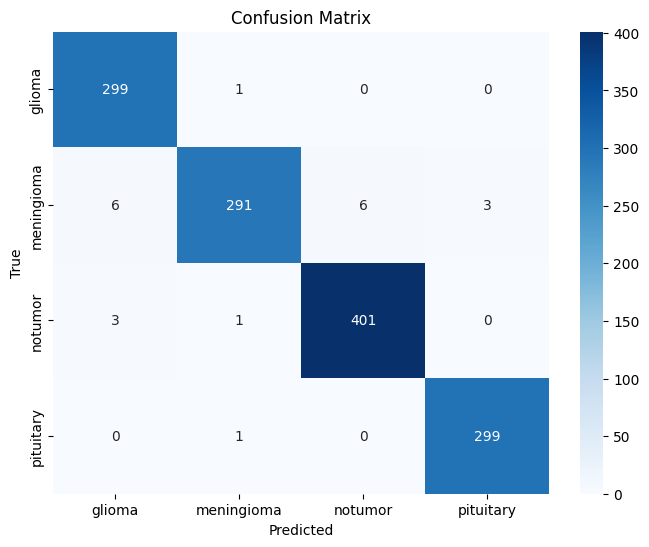

              precision    recall  f1-score   support

      glioma       0.97      1.00      0.98       300
  meningioma       0.99      0.95      0.97       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [41]:



model = load_model("best_brain_tumor_model.keras")


labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))



In [51]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model("best_brain_tumor_model.keras")

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

image_path = "/content/drive/MyDrive/Braintumor classification/Testing/notumor/Te-noTr_0000.jpg"

image_size = 150
img = cv2.imread(image_path, 0)
img = cv2.bilateralFilter(img, 2, 50, 50)
img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
img = cv2.resize(img, (image_size, image_size))
img = img / 255.0
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
class_index = np.argmax(pred)
print("Predicted class:", labels[class_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: notumor
